In [19]:
import tushare as ts
import matplotlib.pyplot as plt

ts.set_token('5305de6debee3bf1ea4cb89a0757d052dedb6ae9f54c565d28c2d098')
pro = ts.pro_api()

df = pro.daily(ts_code='600438.SH', start_date='20100101', end_date='20230901')

datapath1 = "./SH600438.csv"
df.to_csv(datapath1)

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [21]:
tongwei = pd.read_csv('./SH600438.csv')
tongwei

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,600438.SH,20230901,32.12,32.49,32.01,32.16,32.08,0.08,0.2494,134452.54,432944.482
1,1,600438.SH,20230831,32.45,32.74,32.08,32.08,32.48,-0.40,-1.2315,206198.73,666379.761
2,2,600438.SH,20230830,32.71,32.92,32.41,32.48,32.71,-0.23,-0.7031,191318.90,624812.633
3,3,600438.SH,20230829,32.47,32.91,32.39,32.71,32.46,0.25,0.7702,283558.00,927106.655
4,4,600438.SH,20230828,33.81,33.83,32.25,32.46,31.59,0.87,2.7540,473892.73,1560214.950
...,...,...,...,...,...,...,...,...,...,...,...,...
3166,3166,600438.SH,20100108,10.65,10.76,10.38,10.74,10.65,0.09,0.8500,62083.86,65783.145
3167,3167,600438.SH,20100107,10.90,10.98,10.58,10.65,10.92,-0.27,-2.4700,89826.40,96851.943
3168,3168,600438.SH,20100106,11.10,11.26,10.90,10.92,11.06,-0.14,-1.2700,105923.89,117164.832
3169,3169,600438.SH,20100105,10.83,11.07,10.70,11.06,10.84,0.22,2.0300,126557.76,138238.886


In [22]:
training_set = tongwei.iloc[0:3170 - 300, 3:4].values
test_set = tongwei.iloc[3170 - 300:, 3:4].values

In [23]:
# Normalization
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

In [24]:
x_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])

np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))

In [25]:
x_test = []
y_test = []

for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [26]:
model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100, return_sequences=True),
    Dropout(0.2),
    GRU(80),
    Dropout(0.2),
    Dense(1)
])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
              loss='mean_squared_error') 

In [28]:
checkpoint_save_path = "./checkpoint/stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

In [29]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

Epoch 1/50
44/44 [==============================] - 8s 99ms/step - loss: 0.0109 - val_loss: 1.7857e-04
Epoch 2/50
44/44 [==============================] - 4s 81ms/step - loss: 0.0014 - val_loss: 1.0151e-04
Epoch 3/50
44/44 [==============================] - 4s 83ms/step - loss: 0.0012 - val_loss: 9.0828e-05
Epoch 4/50
44/44 [==============================] - 4s 84ms/step - loss: 0.0012 - val_loss: 7.0817e-05
Epoch 5/50
44/44 [==============================] - 4s 86ms/step - loss: 0.0012 - val_loss: 7.0195e-05
Epoch 6/50
44/44 [==============================] - 4s 89ms/step - loss: 0.0012 - val_loss: 8.3689e-05
Epoch 7/50
44/44 [==============================] - 4s 89ms/step - loss: 0.0011 - val_loss: 6.7028e-05
Epoch 8/50
44/44 [==============================] - 4s 86ms/step - loss: 0.0011 - val_loss: 8.2000e-05
Epoch 9/50
44/44 [==============================] - 4s 88ms/step - loss: 9.8017e-04 - val_loss: 5.4182e-05
Epoch 10/50
44/44 [==============================] - 4s 90ms/step - l

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 60, 80)            19920     
                                                                 
 dropout_6 (Dropout)         (None, 60, 80)            0         
                                                                 
 gru_7 (GRU)                 (None, 60, 100)           54600     
                                                                 
 dropout_7 (Dropout)         (None, 60, 100)           0         
                                                                 
 gru_8 (GRU)                 (None, 80)                43680     
                                                                 
 dropout_8 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [31]:
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

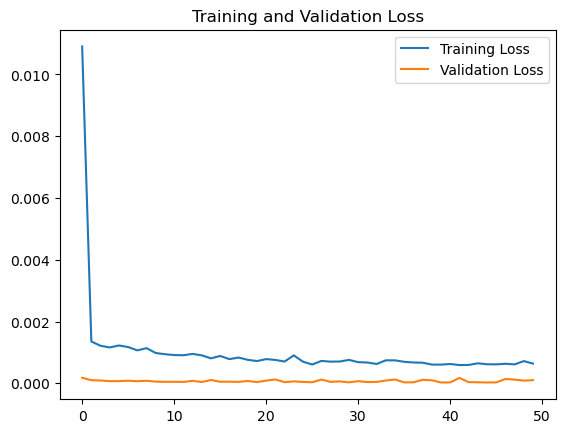

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(test_set[60:])

8/8 [==============================] - 2s 33ms/step


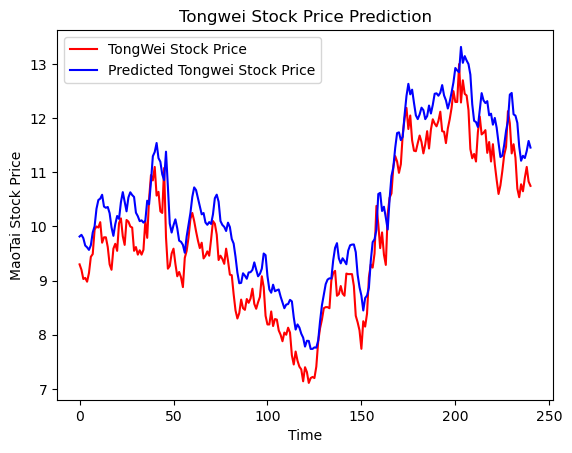

In [34]:
plt.plot(real_stock_price, color='red', label='TongWei Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Tongwei Stock Price')
plt.title('Tongwei Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()

In [35]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('rmse: %.6f' % rmse)
print('mae: %.6f' % mae)

rmse: 0.630315
mae: 0.562637


In [37]:
# predict future stock price
future_stock_price = np.array(test_set[-1, 0])
base = y_test

for i in range(7):
    price = model.predict(np.reshape(base[-60:], (1, 60, 1)))
    base = np.append(base, price)
    future_stock_price = np.append(future_stock_price, price)
    
future_stock_price = np.reshape(future_stock_price, (future_stock_price.shape[0], 1))
future_stock_price = sc.inverse_transform(future_stock_price)

1/1 [==============================] - 0s 40ms/step


In [38]:
t = np.reshape(y_test, (y_test.shape[0], 1))
t = sc.inverse_transform(t)
t2 = model.predict(np.reshape(y_test[-60:], (1, 60, 1)))
t2 = sc.inverse_transform(t2)
future_stock_price

1/1 [==============================] - 0s 39ms/step


array([[10.75      ],
       [11.34347483],
       [11.7103256 ],
       [12.10352572],
       [12.47957763],
       [12.84757285],
       [13.21210407],
       [13.57514248]])

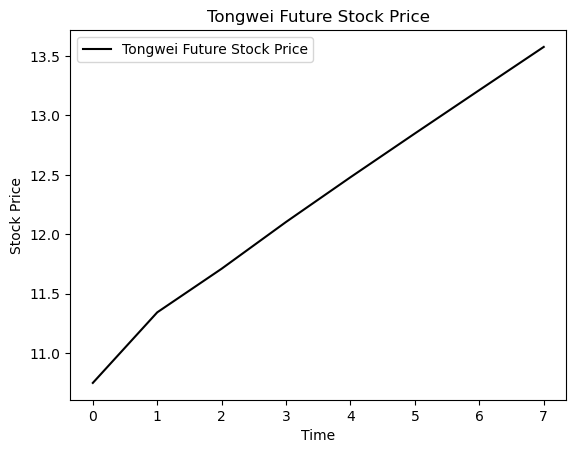

In [40]:
plt.plot(future_stock_price, color='black', label='Tongwei Future Stock Price')
plt.title('Tongwei Future Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()